In [1]:
using ApproxFun, Poltergeist, Plots

### The map $f_n$

In [2]:
const Uc = 0.97; # a number that turns up a lot

struct InvMap <: Function # struct encoding an inverse branch of the map
    K::Float64            # value of coupling parameter
    i::Int                # branch index, ∈ {±1}
end
(v::InvMap)(q) = (q + v.i + v.K*(1-sqrt(1 - Uc*(1-q^2))))/2 # an InvMap can be called like a function

f_map(K) = MarkovMap([InvMap(K,-1),InvMap(K,1)], # inverse branches
                     [-1.0..0.0,0.0..1.0],       # domains of inverse branches
                     dir=Reverse                 # defining via inverse
                    ) # initialises full-branch map for given K

f_map (generic function with 1 method)

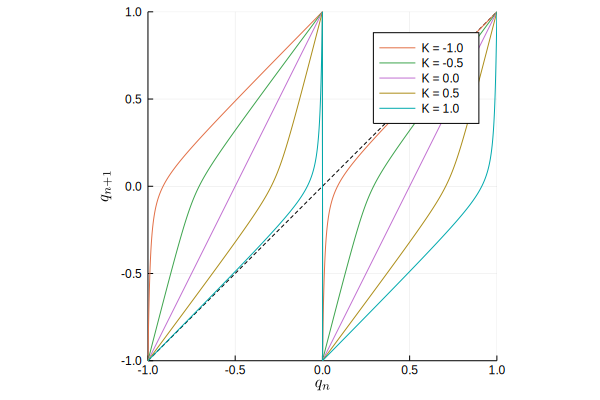

In [3]:
pts = -1:0.001:1
plot(pts, pts, color="black", style=:dash, label="")
for K = (-1:0.5:1)
    plot!(pts, f_map(K).(pts), label="K = $K")
end
plot!(xaxis=("\$q_n\$", (-1,1)) ,yaxis=("\$q_{n+1}\$", (-1,1)), aspect_ratio=:equal)

### The coupled system

In [4]:
const pbasis = Chebyshev(-1.0..1.0) # polynomial basis
const ϕ = Fun(q->-23/30+7q^2/2-2q^4, pbasis) # Chebyshev approximation of the coupling function ϕ
get_Φ(μ_n) = sum(ϕ * μ_n)

# Outputs μ_{n+1} and Φ_{n+1} given inputs μ_n, ε and driving d, which is by default Φ_{n}
function F(μ_n, ε, d_n = get_Φ(μ_n))
    K_n = tanh(d_n*ε-2)
    f_n = f_map(K_n)
    μ_n1 = transfer(f_n,μ_n)
    μ_n1, get_Φ(μ_n1)
end

F (generic function with 2 methods)

### Dynamics

In [5]:
μ = 1 + 0.3Fun(pbasis,rand(6)); # randomised initial distribution of q^(j)
μ /= sum(μ) # to make a probability measure 
ε = 30
for i = 1:20
    μ, Φ = F(μ,ε)
    println(Φ)
end

0.04506728057122921
0.097724123100626
-0.06939051059330183
0.015021609789111767
0.08667205075091453
-0.0534275945398123
0.03629101294850169
0.06338571530439102
0.016149334611417945
0.0767699591342954
-0.021810393909983176
0.05624518204656115
0.026659277528371265
0.08092502317273104
-0.03180070048389576
0.047028697612824535
0.04761932910689239
0.05752205223620578
0.040155102818015355
0.0656562981512754


### Code speed

In [6]:
@time for i = 1:1000
    global μ # need inside @time macro
    μ, _ = F(μ,ε)
end

  0.746444 seconds (6.14 M allocations: 250.485 MiB, 8.05% gc time)


### Attractor

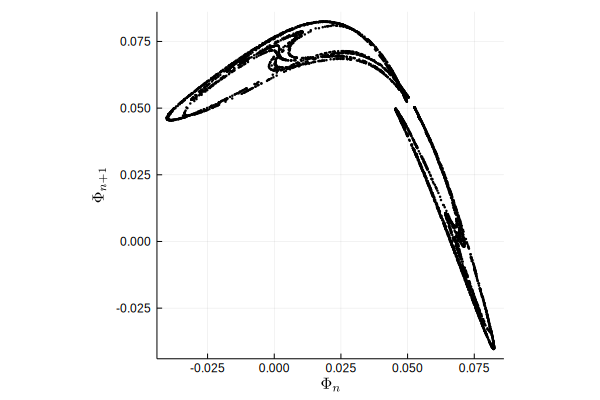

In [7]:
N = 5000
Φh = Array{Float64}(undef,N)

for i = 1:1000 #spinup
    μ, Φ = F(μ,ε)
end

for i = 1:N
    μ, Φh[i] = F(μ,ε)
end
scatter(Φh[1:end-1],Φh[2:end],markersize=1.5,markerstrokewidth=0,markercolor=:black,label="",
    xlabel="\$\\Phi_n\$", ylabel="\$\\Phi_{n+1}\$", aspect_ratio=:equal)